## Introduction
https://www.kaggle.com/code/lxyuan0420/facial-expression-recognition-using-cnn#It-was-a-fun-project,-Happy-Kaggling-:)-
From Kaggle open resource, we make use of 48*48 pixels grayscale images of 7 emotions. Taken from the FER2013 dataset and the Random Images for Face Emotion dataset.

Image set of 34,059 with training-set (after combining FER2013 and Random Images for Face Emotion: 10% validation and 10% test set fixed by the competition.


## Objectives
(i) To apply Convolutional neural networks (CNN) for facial expression recognition.
 
(ii) To correctly classify each facial image into one of the seven facial emotion categories: **anger**, **disgust**, **fear**, **happiness**, **sadness**, **surprise**, and **neutral**.


---------------------------------------------------------------------------------------
## 1. Import libraries

In [1]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['facialexpressionrecognition', 'random-images-for-face-emotion-recognition']


## 2. Functions

In [2]:
#Display sample emotion images
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

In [3]:
#Axes to compare number of emotions per dataset
def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

In [4]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape:", data_X.shape, dataName, "_Y shape:", data_Y.shape)
    #print(data_X) #[[[0.27450982]
    #print(data_Y) #[[1. 0. 0. ... 0. 0. 0.]
    return data_X, data_Y

In [5]:
def plot_training(results):
    fig, axes = plt.subplots(1,2, figsize=(18, 6))
    # Plot training & validation accuracy values
    axes[0].plot(results.history['acc'])
    axes[0].plot(results.history['val_acc'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axes[1].plot(results.history['loss'])
    axes[1].plot(results.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [6]:
##Functions

#Plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [7]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# early stopping
es = EarlyStopping(monitor='val_loss', patience = 15, mode = 'min', restore_best_weights=True)

## 1st Dataset Overview

In [8]:
data = pd.read_csv('/kaggle/input/facialexpressionrecognition/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [9]:
#preview first 5 row of data
data.head(15)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [10]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [11]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


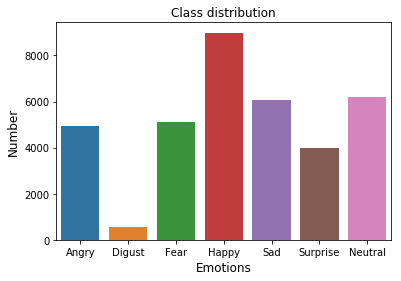

In [12]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [13]:
# Update the emotion column with new indices
data['emotion'] = data['emotion'].rank(method='dense').astype(int) - 1

#### Let's look at some images...

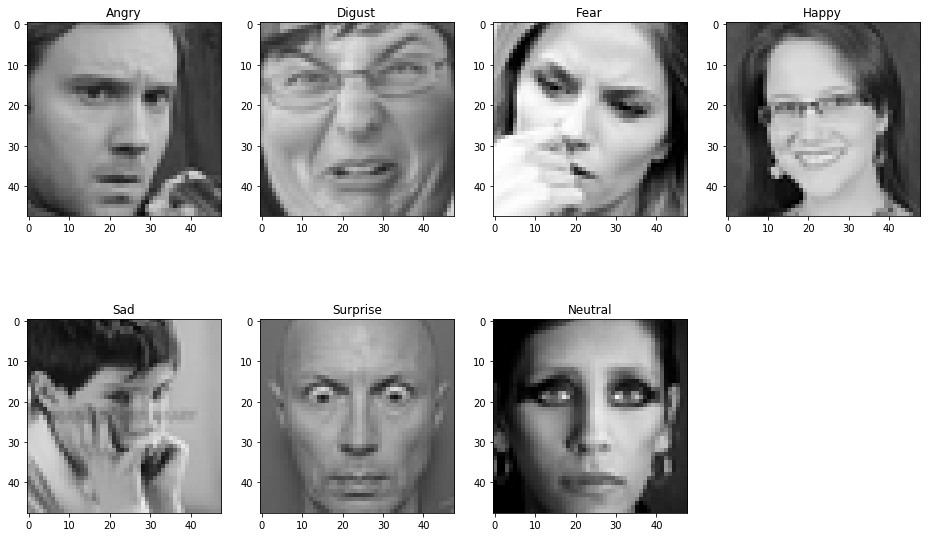

In [14]:
plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

## Dataset 2 overview

In [15]:
data_2_path = '/kaggle/input/random-images-for-face-emotion-recognition'
data_2_dir_list = os.listdir(data_2_path)

img_data_list = []
emotion_list = []

# Define a mapping from emotion names to numerical labels
emotion_mapping = {
    'anger': 0,
    'contempt': 1,
    'disgust': 2,
    'fear': 3,
    'happiness': 4,
    'neutrality': 5,
    'sadness': 6,
    'surprise': 7
}

for dataset in data_2_dir_list:
    if dataset in emotion_mapping:
        img_list = os.listdir(data_2_path+'/'+ dataset)
        print('Loaded the images of dataset-'+'{}\n'.format(dataset))
        emotion = emotion_mapping[dataset]
        for img in img_list:
            input_img = cv2.imread(data_2_path + '/' + dataset + '/' + img)
            if input_img is not None:
                # Convert BGR to grayscale images
                gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
                # Resize to 48 x 48 pixels
                input_img_resize = cv2.resize(gray_img, (48, 48))
                img_data_list.append(input_img_resize.flatten())  # Flatten to a 1D array
                emotion_list.append(emotion)

data_2 = np.array(img_data_list)

# Create a DataFrame
columns = [f'pixel_{i}' for i in range(data_2.shape[1])]
df = pd.DataFrame(data_2, columns=columns)

# Add 'emotion' and 'Usage' columns
df['emotion'] = emotion_list
df['Usage'] = 'Training'  # Assuming all data is used for training

# Concatenate pixel values into a 'pixels' column
df['pixels'] = df.apply(lambda row: ' '.join(row[columns].values.astype(str)), axis=1)

# Drop the individual pixel columns
df = df.drop(columns=columns)

# Reorder columns to match the desired format
df = df[['emotion', 'pixels', 'Usage']]

Loaded the images of dataset-surprise

Loaded the images of dataset-fear

Loaded the images of dataset-sadness

Loaded the images of dataset-neutrality

Loaded the images of dataset-disgust

Loaded the images of dataset-contempt

Loaded the images of dataset-happiness

Loaded the images of dataset-anger



In [16]:
# Display the DataFrame
df.head(5)

,emotion,pixels,Usage
0,7,67 47 44 43 44 43 45 46 45 42 46 59 73 76 75 8...,Training
1,7,190 197 203 205 206 216 173 170 130 83 137 174...,Training
2,7,160 126 142 105 98 109 124 132 136 115 110 105...,Training
3,7,151 211 199 200 213 200 213 211 210 211 208 20...,Training
4,7,11 11 18 55 66 71 89 110 111 108 100 115 100 1...,Training


In [17]:
#check usage values
#100% training
df.Usage.value_counts()

Training    5558
Name: Usage, dtype: int64

In [18]:
#check target labels
emotion_map = {0: 'Angry', 1:'Contempt',2: 'Digust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,890
1,Happy,1406
2,Contempt,208
3,Neutral,524
4,Digust,439
5,Sad,746
6,Fear,570
7,Surprise,775


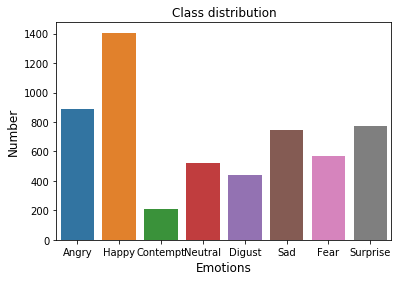

In [19]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

To remove the emotion 'Contempt' from the dataset since it is not very applicable for Interviewing applicants. It is also with the least amount of data at 208, when the average for the others are 1000 range

In [20]:
distinct_values = df['emotion'].unique()
print(distinct_values)

[7 3 6 5 2 1 4 0]


In [21]:
emotion_map = {0: 'Angry', 1:'Contempt',2: 'Digust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
# Define the mapping from the current emotion numbers to the desired order
emotion_mapping = {0: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 5: 6}

# Remove rows with emotion 'Contempt'
df = df[df['emotion'] != 1]

# Apply the mapping to create a new 'emotion' column
df['emotion'] = df['emotion'].map(emotion_mapping)

# Fill NaN values with NaN
df['emotion'] = df['emotion'].fillna(np.nan)

# Reset index
df = df.reset_index(drop=True)

In [22]:
distinct_values = df['emotion'].unique()
print(distinct_values)


[5 2 4 6 1 3 0]


In [23]:
#check target labels of modified dataframe
emotion_map = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,890
1,Sad,746
2,Disgust,439
3,Surprise,775
4,Fear,570
5,Neutral,524
6,Happy,1406


In [24]:
#Check if count decreased by 200
df.shape

(5350, 3)

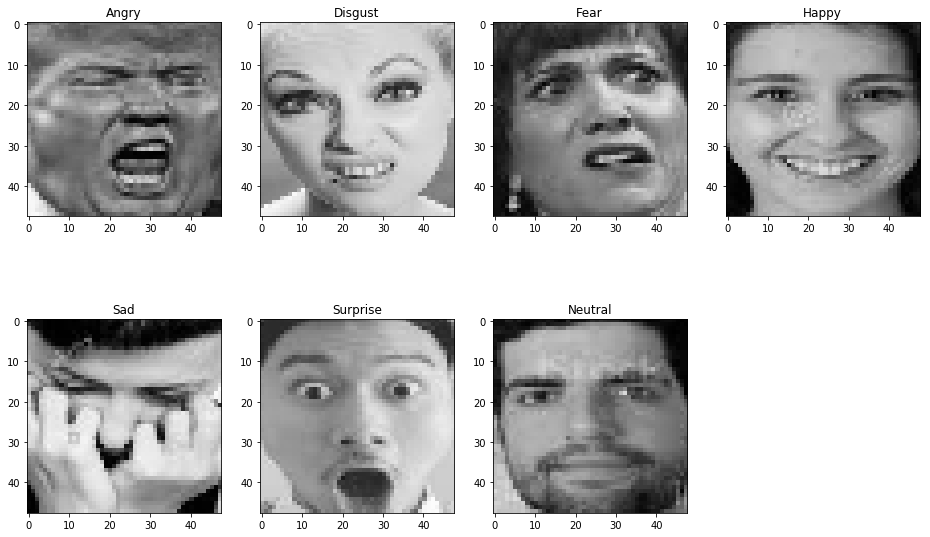

In [25]:
plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

----------------------------------------------------------------------------------
## Pre-processing data
#### Summary:
1. Splitting dataset into 3 parts: train, validation, test
1. Convert strings to lists of integers
1. Reshape to 48x48 and normalise grayscale image with 255.0
1. Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [26]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_train = data_train.append(df,ignore_index=True)
data_val   = data[data['Usage']=='PublicTest'].copy() 
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (34059, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [27]:
data_train.emotion.value_counts()

3    8621
4    5576
6    5489
0    4885
2    4667
5    3946
1     875
Name: emotion, dtype: int64

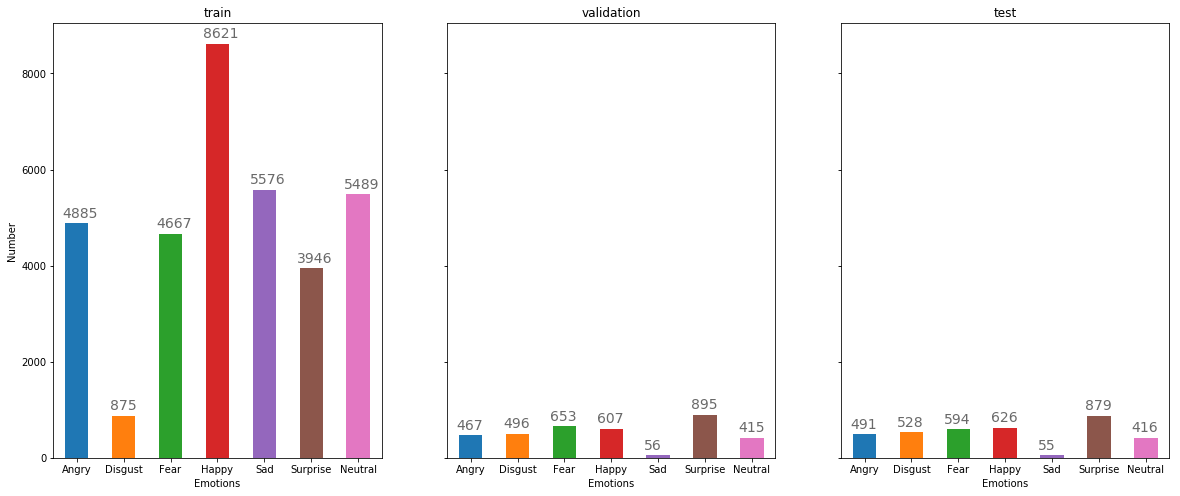

In [28]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

# Notice that the later two subplots share the same y-axis with the first subplot. 

The size of **train**, **validation**, **test** are **80%**, **10%** and **10%**, respectively. 

The exact number of each class of these datasets are written on top of their x-axis bar. 

In [29]:
#initilize parameters
num_classes = 7
width, height = 48, 48
num_epochs = 100
batch_size = 32

In [30]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]
    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: (34059, 48, 48, 1) train _Y shape: (34059, 7)
val _X shape: (3589, 48, 48, 1) val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1) test _Y shape: (3589, 7)


----------------------------------------------------------------------------------
## CNN Model Architecture Experimentation
1. VGG-16
2. ResNet18
3. Inspired VGG-16

In [118]:
#initilize parameters
num_classes = 7
width, height = 48, 48
num_epochs = 100
batch_size = 32

### First Model Experimentation

In [119]:
#VGG-16 Model
model_1 = Sequential()

# Module 1
model_1.add(Conv2D(64, kernel_size=(3, 3), input_shape=(width, height, 1), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 2
model_1.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 3
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten
model_1.add(Flatten())

# Dense layers
model_1.add(Dense(4096))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dense(4096))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_17 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_17 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 24, 24, 64)        0         
__________

In [120]:
history_1 = model_1.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/100
 - 77s - loss: 2.2473 - acc: 0.2620 - val_loss: 5.7023 - val_acc: 0.2572
Epoch 2/100
 - 71s - loss: 1.9814 - acc: 0.3479 - val_loss: 1.5672 - val_acc: 0.4023
Epoch 3/100
 - 71s - loss: 1.6954 - acc: 0.4218 - val_loss: 2.3508 - val_acc: 0.4009
Epoch 4/100
 - 71s - loss: 1.4803 - acc: 0.4612 - val_loss: 1.3434 - val_acc: 0.4862
Epoch 5/100
 - 71s - loss: 1.3195 - acc: 0.5130 - val_loss: 1.2074 - val_acc: 0.5330
Epoch 6/100
 - 71s - loss: 1.2317 - acc: 0.5427 - val_loss: 1.2483 - val_acc: 0.5188
Epoch 7/100
 - 71s - loss: 1.1727 - acc: 0.5661 - val_loss: 1.1250 - val_acc: 0.5773
Epoch 8/100
 - 71s - loss: 1.1323 - acc: 0.5788 - val_loss: 1.1683 - val_acc: 0.5765
Epoch 9/100
 - 71s - loss: 1.0959 - acc: 0.5945 - val_loss: 1.1006 - val_acc: 0.5834
Epoch 10/100
 - 71s - loss: 1.0501 - acc: 0.6094 - val_loss: 1.0415 - val_acc: 0.6124
Epoch 11/100
 - 71s - loss: 1.0104 - acc: 0.6208 - val_loss: 1.0420 - val_acc: 0.6144
Epoch 12/100
 - 71s - loss: 0.9861 - acc: 0.6307 - val_loss: 1.

## 1. VGG-16 Model Visualize Training Performance

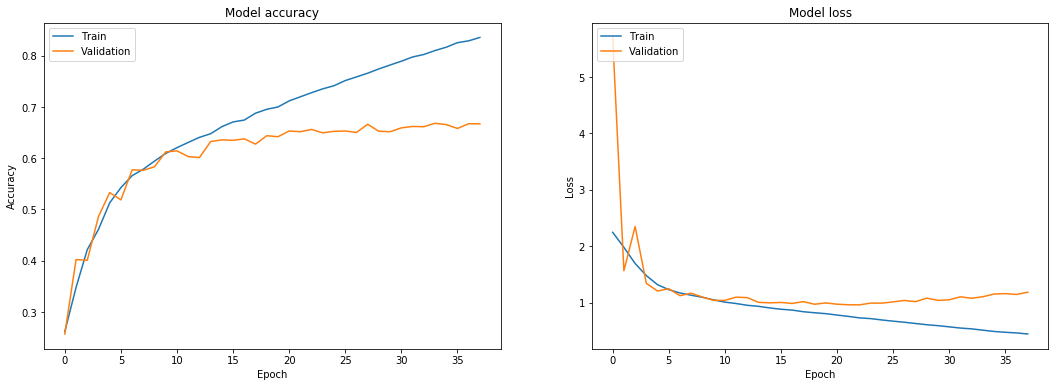

In [121]:
plot_training(history_1)

## 1. VGG-16 Model Evaluate Test Performance

In [162]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model_1.predict(test_X), axis=1)
vgg_16_score = accuracy_score(test_true, test_pred)
print("1.VGG-16 CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

1.VGG-16 CNN Model Accuracy on test set: 0.6818


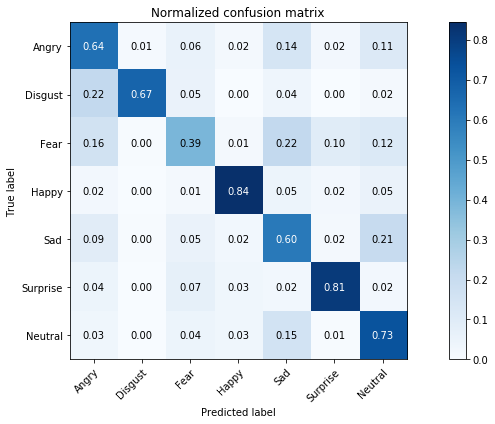

In [127]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

### 2nd Model Experimentation

In [138]:
# # ResNet18 architecture

def identity_block(x, filters):
    # Identity block for ResNet-18
    x_skip = x
    
    # First layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second layer
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Skip connection
    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    
    return x

def conv_block(x, filters, strides=(2, 2)):
    # Convolutional block for ResNet-18
    x_skip = x
    
    # First layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Skip connection
    x_skip = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)
    
    # Add the skip connection
    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    
    return x

def resnet18(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential()

    # Initial convolutional layer
    model.add(Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    # Residual blocks
    x = conv_block(model.output, 64, strides=(1, 1))
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = conv_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = conv_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = conv_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)

    # Global Average Pooling
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=model.input, outputs=x)

    return model

# Instantiate the ResNet-18 model
model_2 = resnet18(input_shape=(48, 48, 1), num_classes=7)

# Compile the model
model_2.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_194_input (InputLayer)   (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 24, 24, 64)   3200        conv2d_194_input[0][0]           
__________________________________________________________________________________________________
batch_normalization_132 (BatchN (None, 24, 24, 64)   256         conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_117 (Activation)     (None, 24, 24, 64)   0           batch_normalization_132[0][0]    
__________________________________________________________________________________________________
max_poolin

In [139]:
history_2 = model_2.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=100,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/100
 - 80s - loss: 1.7084 - acc: 0.3397 - val_loss: 1.6943 - val_acc: 0.3176
Epoch 2/100
 - 63s - loss: 1.4782 - acc: 0.4356 - val_loss: 1.6321 - val_acc: 0.4154
Epoch 3/100
 - 64s - loss: 1.3830 - acc: 0.4769 - val_loss: 1.9268 - val_acc: 0.2809
Epoch 4/100
 - 64s - loss: 1.3195 - acc: 0.5064 - val_loss: 1.5436 - val_acc: 0.4361
Epoch 5/100
 - 63s - loss: 1.2631 - acc: 0.5259 - val_loss: 1.3142 - val_acc: 0.4854
Epoch 6/100
 - 63s - loss: 1.2561 - acc: 0.5338 - val_loss: 1.3123 - val_acc: 0.5038
Epoch 7/100
 - 64s - loss: 1.5039 - acc: 0.4374 - val_loss: 1.4108 - val_acc: 0.4497
Epoch 8/100
 - 63s - loss: 1.2223 - acc: 0.5396 - val_loss: 1.2109 - val_acc: 0.5386
Epoch 9/100
 - 63s - loss: 1.3022 - acc: 0.5198 - val_loss: 1.4287 - val_acc: 0.4168
Epoch 10/100
 - 64s - loss: 1.2091 - acc: 0.5499 - val_loss: 1.4501 - val_acc: 0.4436
Epoch 11/100
 - 64s - loss: 1.1457 - acc: 0.5697 - val_loss: 1.4514 - val_acc: 0.4377
Epoch 12/100
 - 63s - loss: 1.1561 - acc: 0.5691 - val_loss: 1.

## 2. ResNet-18 Model Visualize Training Performance

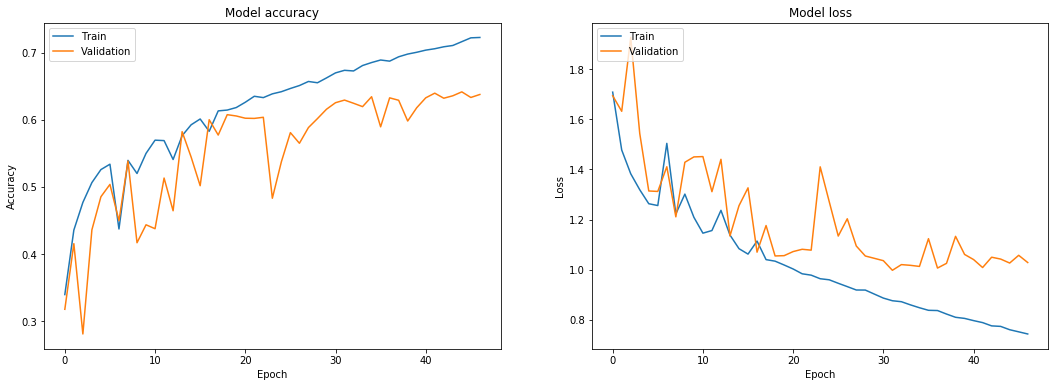

In [140]:
plot_training(history_2)

## 2. ResNet-18 Model Evaluate Test Performance

In [141]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model_2.predict(test_X), axis=1)
resnet_18_score = accuracy_score(test_true, test_pred)
print("2. ResNet-18 CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

2. ResNet-18 CNN Model Accuracy on test set: 0.6422


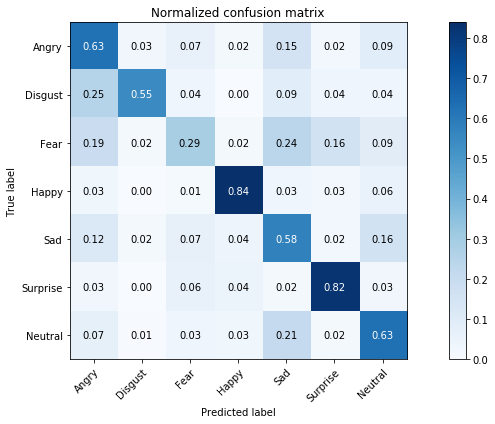

In [142]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

## 3. Improved VGG-16 model
Since VGG-16 achieved a 0.68 accuracy with overfitting but smoother learning curves and ResNet-18 achieved a 0.64 accuracy with overfitting and very volatile learning curves, we have decided to improve on the VGG-16, prevent overfitting and try to improve the learning curves. 

In [145]:
# https://www.kaggle.com/code/infinator/mood-detection-and-song-recommendation#Result
#link 1, Improved VGG 68% acc
#Improved VGG-16 inspired model with increased dropout and regularization

model_3 = Sequential()

# Initial Convolutional layer
model_3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(width, height, 1)))
model_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(2, 2))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(1024, activation='relu'))
model_3.add(Dropout(0.5))
    
model_3.add(Dense(num_classes, activation='softmax'))

model_3.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) #Final Test Acc 0.6824

# Display model summary
model_3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_231 (Conv2D)          (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_167 (Bat (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_233 (Conv2D)          (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 22, 22, 256)       295168    
__________

In [146]:
history_3 = model_3.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=100,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/100
 - 53s - loss: 4.0973 - acc: 0.2599 - val_loss: 3.3052 - val_acc: 0.3525
Epoch 2/100
 - 46s - loss: 2.9958 - acc: 0.3217 - val_loss: 2.4846 - val_acc: 0.4043
Epoch 3/100
 - 46s - loss: 2.3272 - acc: 0.3738 - val_loss: 1.9136 - val_acc: 0.4698
Epoch 4/100
 - 46s - loss: 1.9077 - acc: 0.4243 - val_loss: 1.6731 - val_acc: 0.4820
Epoch 5/100
 - 46s - loss: 1.6529 - acc: 0.4659 - val_loss: 1.5108 - val_acc: 0.5032
Epoch 6/100
 - 46s - loss: 1.4999 - acc: 0.4972 - val_loss: 1.3473 - val_acc: 0.5483
Epoch 7/100
 - 46s - loss: 1.4080 - acc: 0.5181 - val_loss: 1.3385 - val_acc: 0.5380
Epoch 8/100
 - 46s - loss: 1.3444 - acc: 0.5347 - val_loss: 1.2444 - val_acc: 0.5667
Epoch 9/100
 - 46s - loss: 1.3004 - acc: 0.5466 - val_loss: 1.1937 - val_acc: 0.5784
Epoch 10/100
 - 46s - loss: 1.2604 - acc: 0.5564 - val_loss: 1.2723 - val_acc: 0.5673
Epoch 11/100
 - 46s - loss: 1.2343 - acc: 0.5700 - val_loss: 1.2377 - val_acc: 0.5690
Epoch 12/100
 - 46s - loss: 1.2042 - acc: 0.5793 - val_loss: 1.

## 3. Improved VGG-16 Model Visualize Training Performance

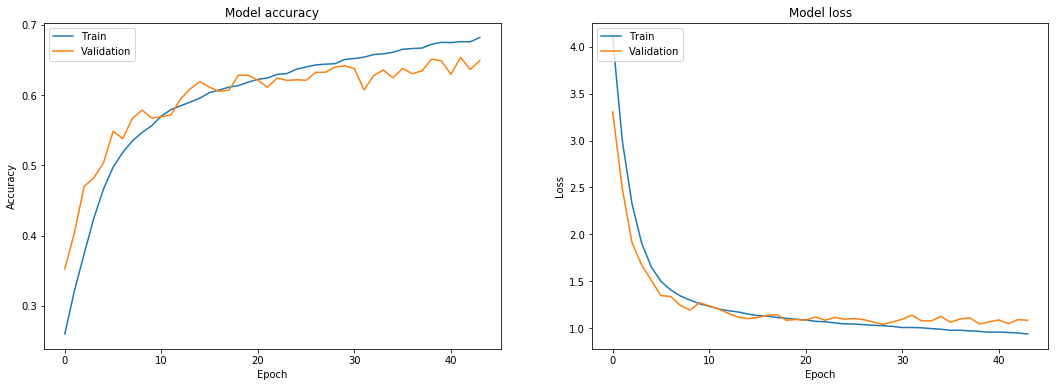

In [147]:
plot_training(history_3)


## 3. Improved VGG-16 Model Evaluate Test Performance

In [148]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model_3.predict(test_X), axis=1)
improved_vgg_16_score = accuracy_score(test_true, test_pred)
print("3. Improved VGG-16 Inspired CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

3. Improved VGG-16 Inspired CNN Model Accuracy on test set: 0.6545


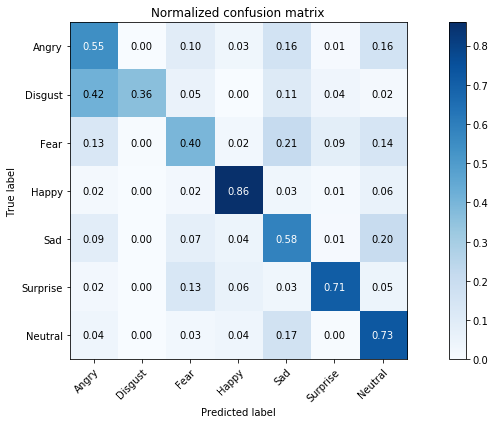

In [149]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

### Model Comparison Table
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        table {
            width: 100%;
            border-collapse: collapse;
            margin-bottom: 20px;
        }
        th, td {
            border: 1px solid #dddddd;
            text-align: left;
            padding: 8px;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
</head>
<body>

<table>
    <tr>
        <th> </th>
        <th>VGG-16 Model</th>
        <th>ResNet-18 Model</th>
        <th>Improved VGG-16 Model</th>
    </tr>
    <tr>
        <th>Accuracy</th>
        <td>68.18%</td>
        <td>64.22%</td>
        <td>65.45%</td>
    </tr>
        <tr>
        <th>Parameters</th>
        <td>Total params: 56,334,535
Trainable params: 56,315,847
Non-trainable params: 18,688</td>
        <td>Total params: 18,947,527
Trainable params: 18,932,423
Non-trainable params: 15,104</td>
        <td>Total params: 32,116,743
Trainable params: 32,116,103
Non-trainable params: 640</td>
    </tr>
    <tr>
        <th>Epochs</th>
        <td>36</td>
        <td>47</td>
        <td>44</td>
    </tr>
    <tr>
        <th>Training Time</th>
        <td>42 minutes</td>
        <td>49 minutes</td>
        <td>33 minutes</td>
    </tr>
    <tr>
        <th>Learning Curves & Overfitting</th>
        <td>Slightly volatile curves with noticeable overfitting (20% accuracy difference)</td>
        <td>Rough and volatile curves with some overfitting (10% accuracy difference)</td>
        <td>Smooth curves with minimal overfitting</td>
    </tr>
    <tr>
        <th>Overall</th>
        <td>Best accuracy but overfitting is too strong. Training time is also relatively long for only 36 epochs</td>
        <td>Worst accuracy and some signs of overfitting, longest training time as well</td>
        <td>Decent accuracy with good learning curves, no signs of overfitting and the shortest training time. Thus, Model 3 will proceed as final model</td>
    </tr>
</table>

</body>
</html>


## Hyperparameter Tuning 
Since Improved VGG-16 has much smoother learning curves and a decent accuracy of 0.65, with more epochs and a proper learning rate and optimizer, the Improved VGG-16 is likely the better predicting model. We will proceed with tuning the 3rd Improved VGG-16 model

In [32]:
# Tuning the improved Model VGG-16

def create_model(optimizer=Adam(), learning_rate=0.0001, width=48, height=48):
    model = Sequential()

    # Initial Convolutional layer
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(width, height, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))

    # Instantiate the optimizer with the given learning rate
    if optimizer == 'Adam':
        optimizer = Adam(lr=learning_rate, decay=1e-6)
    elif optimizer == 'RMSprop':
        optimizer = RMSprop(lr=learning_rate, decay=1e-6)
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy']) #Final Test Acc 0.6824
    
    return model

In [33]:
from keras.wrappers.scikit_learn import KerasClassifier 
# Create the model
model_tune = KerasClassifier(build_fn=create_model, epochs=20, batch_size=16, verbose=2)

In [34]:
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import GridSearchCV, StratifiedKFold

#Define parameter range for gridsearchCV
param_grid = {'optimizer':['RMSprop', 'Adam'],'learning_rate':[0.001, 0.0001, 0.00001]}

In [35]:
# Use StratifiedKFold for classification tasks
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [36]:
# Create GridSearchCV instance
grid = GridSearchCV(estimator=model_tune, param_grid=param_grid, cv=cv, scoring='accuracy')

# Fit the model using GridSearchCV
grid_result = grid.fit(train_X, np.argmax(train_Y, axis=1), verbose=0)  # Convert one-hot encoded labels to categorical

In [43]:
# Print grid search results, dynamically checks for existence of keys corresponding to test score
print("Grid search results:")
for i, params in enumerate(grid_result.cv_results_['params']):
    print(f"\nParameters: {params}")
    
    mean_accuracy = grid_result.cv_results_['mean_test_score'][i]
    std_accuracy = grid_result.cv_results_['std_test_score'][i]
    print(f"Mean Accuracy: {mean_accuracy:.4f}, Standard Deviation: {std_accuracy:.4f}")
    
    # Print test scores for each epoch
    epoch_keys = [key for key in grid_result.cv_results_.keys() if 'split' in key and '_test_score' in key]
    total_epochs = max(int(key.split('_')[0][5:]) for key in epoch_keys)
    
    for epoch in range(1, total_epochs + 1):
        epoch_key = f'split{epoch}_test_score'
        if epoch_key in grid_result.cv_results_:
            epoch_score = grid_result.cv_results_[epoch_key][i]
            print(f"Final Scores - Test Score: {epoch_score:.4f}")

print("\n")


Grid search results:

Parameters: {'learning_rate': 0.001, 'optimizer': 'RMSprop'}
Mean Accuracy: 0.2531, Standard Deviation: 0.0000
Final Scores - Test Score: 0.2531
Final Scores - Test Score: 0.2532

Parameters: {'learning_rate': 0.001, 'optimizer': 'Adam'}
Mean Accuracy: 0.2233, Standard Deviation: 0.0421
Final Scores - Test Score: 0.2531
Final Scores - Test Score: 0.1637

Parameters: {'learning_rate': 0.0001, 'optimizer': 'RMSprop'}
Mean Accuracy: 0.5653, Standard Deviation: 0.0068
Final Scores - Test Score: 0.5558
Final Scores - Test Score: 0.5687

Parameters: {'learning_rate': 0.0001, 'optimizer': 'Adam'}
Mean Accuracy: 0.5683, Standard Deviation: 0.0087
Final Scores - Test Score: 0.5708
Final Scores - Test Score: 0.5774

Parameters: {'learning_rate': 1e-05, 'optimizer': 'RMSprop'}
Mean Accuracy: 0.4711, Standard Deviation: 0.0115
Final Scores - Test Score: 0.4741
Final Scores - Test Score: 0.4557

Parameters: {'learning_rate': 1e-05, 'optimizer': 'Adam'}
Mean Accuracy: 0.5402, S

In [38]:
# Print the best parameters and results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.568279 using {'learning_rate': 0.0001, 'optimizer': 'Adam'}


## Final Model Training
Will proceed with the best learning rate and optimizer combination found

In [31]:
# https://www.kaggle.com/code/infinator/mood-detection-and-song-recommendation#Result
#link 1, Improved VGG 68% acc
#Improved VGG-16 inspired model with increased dropout and regularization

model_final = Sequential()

# Initial Convolutional layer
model_final.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(width, height, 1)))
model_final.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D(2, 2))
model_final.add(Dropout(0.25))

model_final.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model_final.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D(pool_size=(2, 2)))
model_final.add(Dropout(0.25))

model_final.add(Flatten())
model_final.add(Dense(1024, activation='relu'))
model_final.add(Dropout(0.5))
    
model_final.add(Dense(num_classes, activation='softmax'))

model_final.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) #Final Test Acc 0.6824

# Display model summary
model_final.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 256)       295168    
__________

In [32]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 50, mode = 'min', restore_best_weights=True)

history_final = model_final.fit_generator(data_generator.flow(train_X, train_Y, 32),
                                steps_per_epoch=len(train_X) / 32,
                                epochs=150,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/150
 - 28s - loss: 4.1405 - acc: 0.2624 - val_loss: 3.3434 - val_acc: 0.3483
Epoch 2/150
 - 24s - loss: 3.0302 - acc: 0.3151 - val_loss: 2.4824 - val_acc: 0.4060
Epoch 3/150
 - 24s - loss: 2.3515 - acc: 0.3667 - val_loss: 2.0297 - val_acc: 0.4188
Epoch 4/150
 - 24s - loss: 1.9324 - acc: 0.4157 - val_loss: 1.7209 - val_acc: 0.4600
Epoch 5/150
 - 24s - loss: 1.6665 - acc: 0.4633 - val_loss: 1.5656 - val_acc: 0.4845
Epoch 6/150
 - 24s - loss: 1.5100 - acc: 0.4919 - val_loss: 1.3261 - val_acc: 0.5478
Epoch 7/150
 - 24s - loss: 1.4201 - acc: 0.5141 - val_loss: 1.3147 - val_acc: 0.5500
Epoch 8/150
 - 24s - loss: 1.3535 - acc: 0.5293 - val_loss: 1.2349 - val_acc: 0.5642
Epoch 9/150
 - 24s - loss: 1.3080 - acc: 0.5434 - val_loss: 1.2005 - val_acc: 0.5857
Epoch 10/150
 - 24s - loss: 1.2705 - acc: 0.5556 - val_loss: 1.1953 - val_acc: 0.5818
Epoch 11/150
 - 24s - loss: 1.2399 - acc: 0.5653 - val_loss: 1.2587 - val_acc: 0.5751
Epoch 12/150
 - 24s - loss: 1.2216 - acc: 0.5679 - val_loss: 1.

## Visualize Training Performance

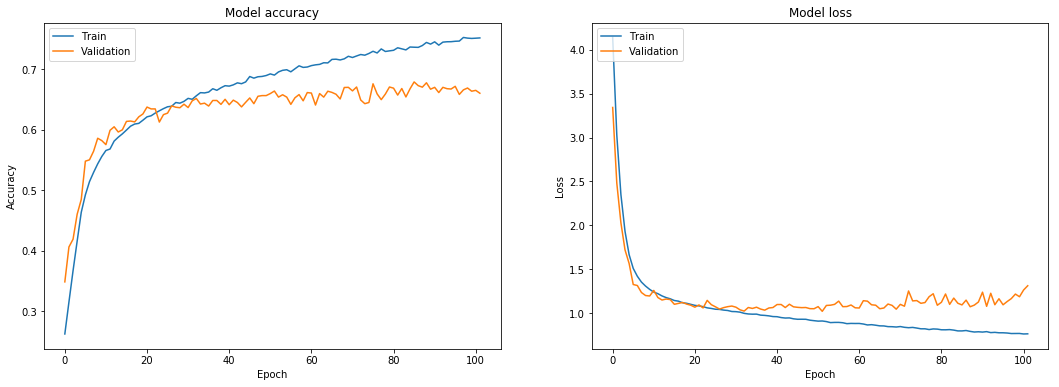

In [33]:
plot_training(history_final)

## Evaluate Test Performance

In [34]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model_final.predict(test_X), axis=1)
print("Final Tuned and Improved VGG-16 CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

Final Tuned and Improved VGG-16 CNN Model Accuracy on test set: 0.6740


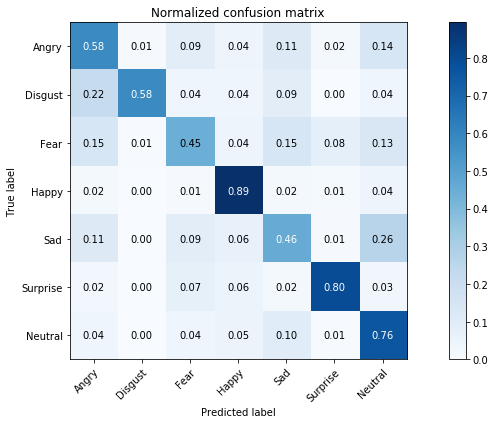

In [35]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [36]:
# Save the model in HDF5 format
model_final.save('improved_vgg_fer.pb')

In [37]:
!mkdir /kaggle/working/model

In [38]:
from tensorflow import keras
model_final = keras.models.load_model('/kaggle/working/improved_vgg_fer.pb')

keras.experimental.export_saved_model(model_final, '/kaggle/working/model')


> ### Amazing! :) 
> ### This is an exciting result because the [model that won the competition had 71.1% accuracy](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard?source=post_page), which means this 67.4% accuracy result puts us into 4th place out of 56 Models! 
        
   ![KaggleRanking](https://i.imgur.com/l8LnPfe.png)